We have GPX and KML extracts from our handheld datalogger - let's figure out how to use GPX data to make a scatterplot visualization of accuracy and precision for the GPSX160 unit.

In [5]:
import gpxpy as gx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pan
import geopy.distance as geo

This is copilot assisted - defining a bunch of helper functions

In [ ]:
def ParseGPX(file_path):
    with open(file_path. 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
    return gpx


def get_points_df(gpx_obj):
    points = []
    for track in gpx_obj.tracks:
        for segment in track.segments:
            for point in segment.points:
                points.append({'time': point.time,
                               'latitude': point.latitude,
                               'longitude': point.longitude,})

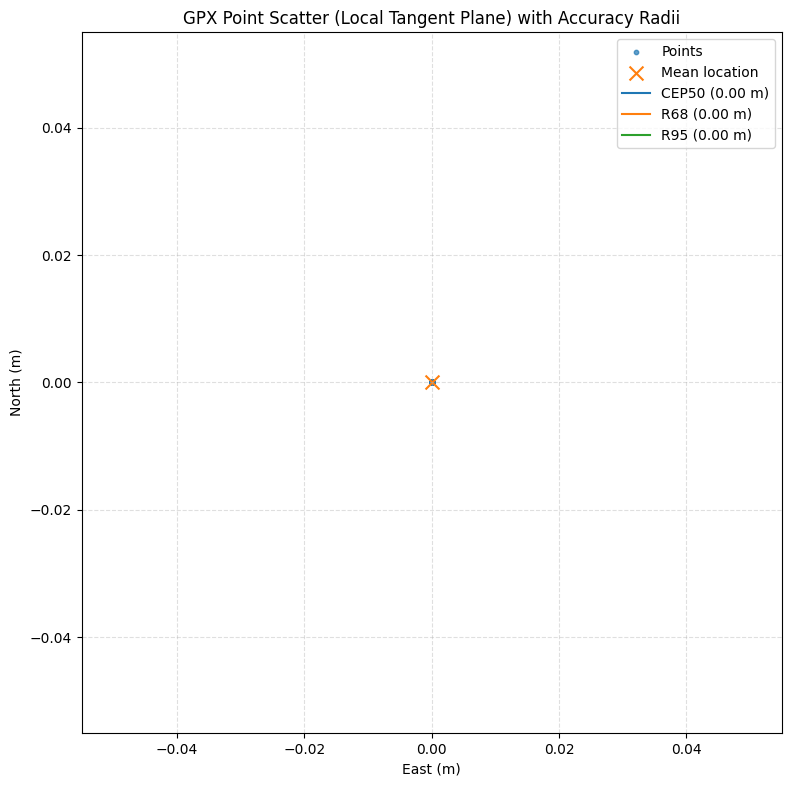

ModuleNotFoundError: No module named 'caas_jupyter_tools'

In [8]:
# This script parses a GPX file, converts latitude/longitude to a local
# metric coordinate frame, computes accuracy/statistics, and makes a scatter
# plot of the collected points with CEP / R68 / R95 reference circles.
#
# It is written as a single, reusable cell so you can download and run it
# locally as `gpx_accuracy.py` with only the Python standard library and
# matplotlib/pandas/numpy required.

import xml.etree.ElementTree as ET
from math import radians, cos, sin, sqrt
from statistics import mean
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# 1) Configure input/output
# -----------------------------
# Path to the uploaded GPX file (adjust if running elsewhere)
gpx_path = Path("/workspaces/BOP_OCTC/Python/20250919_fp.gpx")

# Output artifact paths
points_csv_path = Path("/workspaces/BOP_OCTC/Python/gpx_points.csv")
metrics_csv_path = Path("/workspaces/BOP_OCTC/Python/gpx_metrics.csv")
figure_path = Path("/workspaces/BOP_OCTC/Python/gpx_scatter_accuracy.png")

# -----------------------------
# 2) Parse GPX
# -----------------------------
# We avoid 3rd-party parsers to keep this self-contained.
# GPX <trkpt> elements contain attributes lat/lon and child elements like <ele>, <time>.
# This parser is tolerant of namespaces and missing optional fields.
def parse_gpx_points(gpx_file: Path):
    tree = ET.parse(gpx_file)
    root = tree.getroot()

    # Handle XML namespaces if present: find any namespace used for GPX
    # Example root.tag = "{http://www.topografix.com/GPX/1/1}gpx"
    if root.tag.startswith("{"):
        ns_uri = root.tag.split("}")[0].strip("{")
        ns = {"g": ns_uri}
        trkpt_xpath = ".//g:trkpt"
        ele_xpath = "g:ele"
        time_xpath = "g:time"
    else:
        ns = {}
        trkpt_xpath = ".//trkpt"
        ele_xpath = "ele"
        time_xpath = "time"

    rows = []
    for tp in root.findall(trkpt_xpath, ns):
        lat = float(tp.attrib["lat"])
        lon = float(tp.attrib["lon"])

        # Optional elements
        ele_el = tp.find(ele_xpath, ns)
        time_el = tp.find(time_xpath, ns)

        ele = float(ele_el.text) if ele_el is not None and ele_el.text else None
        t = None
        if time_el is not None and time_el.text:
            # Parse ISO 8601 times like 2025-09-18T20:37:58.0Z
            txt = time_el.text.strip()
            # Normalize 'Z' to +00:00 for fromisoformat compatibility
            if txt.endswith("Z"):
                txt = txt.replace("Z", "+00:00")
            try:
                t = datetime.fromisoformat(txt)
            except Exception:
                # Fallback: try a common strptime format
                try:
                    t = datetime.strptime(time_el.text.strip(), "%Y-%m-%dT%H:%M:%S.%fZ").replace(tzinfo=timezone.utc)
                except Exception:
                    t = None

        rows.append({"lat": lat, "lon": lon, "ele_m": ele, "time": t})

    if not rows:
        raise ValueError("No <trkpt> points found in the GPX file.")

    return pd.DataFrame(rows)


df = parse_gpx_points(gpx_path)

# -----------------------------
# 3) Compute a local metric frame
# -----------------------------
# We use a simple local tangent-plane approximation (good for small areas):
#   x (east, meters)  ≈ (lon - lon0) * cos(lat0) * R
#   y (north, meters) ≈ (lat - lat0) * R
# where R is Earth's mean radius.
R_EARTH = 6371000.0  # meters
lat0 = mean(df["lat"].values)
lon0 = mean(df["lon"].values)
lat0_rad = radians(lat0)

# Convert degrees to radians
lat_rad = np.radians(df["lat"].values)
lon_rad = np.radians(df["lon"].values)
lon0_rad = radians(lon0)

# Local EN (east/north) offsets in meters relative to the mean location
x_east_m = (lon_rad - lon0_rad) * cos(lat0_rad) * R_EARTH
y_north_m = (lat_rad - radians(lat0)) * R_EARTH

df["x_east_m"] = x_east_m
df["y_north_m"] = y_north_m
df["r_radial_m"] = np.sqrt(df["x_east_m"]**2 + df["y_north_m"]**2)

# -----------------------------
# 4) Accuracy statistics
# -----------------------------
# These statistics assume the device was approximately stationary during logging.
# If you moved, the radial spread also reflects trajectory—interpret accordingly.

def circular_error_radius(values, p=0.5):
    """Return the radius (meters) that encloses fraction p of radial distances."""
    return float(np.quantile(values, p))

# Basic counts and timing
n_points = len(df)
t_min = df["time"].min() if df["time"].notna().any() else None
t_max = df["time"].max() if df["time"].notna().any() else None
duration_s = (t_max - t_min).total_seconds() if (t_min and t_max) else None

# Spread statistics (about the mean location)
std_e_m = float(np.std(df["x_east_m"], ddof=1)) if n_points > 1 else 0.0
std_n_m = float(np.std(df["y_north_m"], ddof=1)) if n_points > 1 else 0.0
std_r_m = float(np.std(df["r_radial_m"], ddof=1)) if n_points > 1 else 0.0

# CEP (50%), R68, R95 based on empirical quantiles of radial distances
cep50_m = circular_error_radius(df["r_radial_m"].values, 0.50)
r68_m   = circular_error_radius(df["r_radial_m"].values, 0.68)
r95_m   = circular_error_radius(df["r_radial_m"].values, 0.95)
rmax_m  = float(np.max(df["r_radial_m"].values))

# Mean (lat, lon) — useful as your "best estimate" of true location
mean_lat = lat0
mean_lon = lon0

# Package metrics for display/export
metrics = {
    "n_points": n_points,
    "start_time_utc": t_min.isoformat() if t_min else None,
    "end_time_utc": t_max.isoformat() if t_max else None,
    "duration_seconds": duration_s,
    "mean_lat": mean_lat,
    "mean_lon": mean_lon,
    "std_east_m": std_e_m,
    "std_north_m": std_n_m,
    "std_radial_m": std_r_m,
    "CEP50_m": cep50_m,
    "R68_m": r68_m,
    "R95_m": r95_m,
    "Rmax_m": rmax_m,
}

metrics_df = pd.DataFrame([metrics])

# Persist artifacts
df.to_csv(points_csv_path, index=False)
metrics_df.to_csv(metrics_csv_path, index=False)

# -----------------------------
# 5) Plot: local scatter with CEP/R68/R95
# -----------------------------
# One figure only (per tool guidance). We plot points in the local tangent plane
# with concentric reference circles for CEP50, R68, and R95 centered at (0, 0).

fig, ax = plt.subplots(figsize=(8, 8))

# Scatter of observed points
ax.scatter(df["x_east_m"], df["y_north_m"], s=10, alpha=0.7, label="Points")

# Mark the origin (mean location)
ax.scatter([0], [0], marker="x", s=100, label="Mean location")

# Helper to draw a circle with a given radius (no explicit color/styling)
def add_circle(ax, radius_m, label):
    theta = np.linspace(0, 2*np.pi, 361)
    ax.plot(radius_m * np.cos(theta), radius_m * np.sin(theta), label=label)

# Reference circles
add_circle(ax, cep50_m, f"CEP50 ({cep50_m:.2f} m)")
add_circle(ax, r68_m,   f"R68 ({r68_m:.2f} m)")
add_circle(ax, r95_m,   f"R95 ({r95_m:.2f} m)")

ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("East (m)")
ax.set_ylabel("North (m)")
ax.set_title("GPX Point Scatter (Local Tangent Plane) with Accuracy Radii")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend(loc="best")

fig.tight_layout()
fig.savefig(figure_path, dpi=200)
plt.show()

# -----------------------------
# 6) Display tabular outputs in the UI
# -----------------------------
import caas_jupyter_tools as cj
cj.display_dataframe_to_user("GPX Points (local meters & timestamps)", df)
cj.display_dataframe_to_user("GPX Accuracy Metrics", metrics_df)

# Provide output locations for download
print("Artifacts created:")
print(f"- Points CSV: {points_csv_path}")
print(f"- Metrics CSV: {metrics_csv_path}")
print(f"- Figure PNG: {figure_path}")
